# Exploration 3. 카메라 스티커앱 만들기

얼굴인식을 통하여 적절한 위치에 간단한 스티커를 붙이는 카메라앱을 만들어보자.



✅ __핵심내용__
- 동영상 처리, 검출, 키포인트 수정, 추척, 카메라 원근 이해
- 얼굴인식 카메라의 흐름 이해
- `dlib` 라이브러리
- 이미지 배열의 인덱싱 예외 처리

![image](https://user-images.githubusercontent.com/84179578/126262719-7f42d1b6-ed77-4336-b22d-2a74646ef6e8.png)


## 사진 불러오기

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

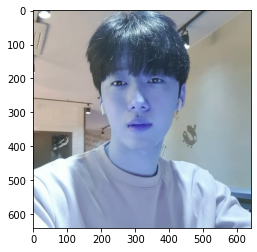

In [2]:
my_image_path ='EP03_data/leejaejun.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 640))    # 640x 640의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

`matplotlib`, `dlib` 에서는 모두 RGB (red, green, blue) 의 채널을 사용한다.  
하지만 `opencv` 에서는 예외적으로 BGR (blue, green, red) 의 채널을 사용한다. -> 따라서 위 사진이 푸르게 보임

따라서 `opencv`에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 색깔 보정처리를 해주어야한다.

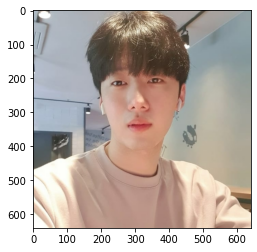

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

 dlib을 활용해 hog detector를 선언한다.

In [4]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

detector를 이용해서 얼굴의 bounding box를 추출한다.

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

`dlib`은 rgb 이미지를 입력으로 받기 때문에 `cvtColor()` 를 이용해서 `opencv` 의 BGR 이미지를 rgb로 변환하였다.  

여기서 `detector_hog` 의 두 번째 파라미터는 이미지 피라미드의 수이다.  이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 한다..
이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.

dlib detector 는 `dlib.rectangles` 타입의 객체를 반환한다.

`dlib.rectangles` 는  `dlib.rectangle` 객체의 배열 형태로 이루어져있다. `dlib.rectangle` 객체에 대한 자세한 내용은 블로그에 정리하겠다.  

-> 링크추가예정

`dlib.rectangle` 객체의 멤버 함수를 통해 찾은 얼굴 영역의 좌표를 찾고 출력해보자.

rectangles[[(191, 167) (414, 390)]]


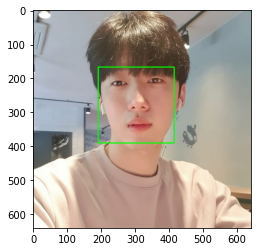

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 얼굴 랜드마크 face landmark

#### Dlib landmark localization
잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾는다.

Dlib의 제공되는 모델을 사용해보겠다. -> 자세한 내용 블로그

In [7]:
model_path = 'EP03_data/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)         # 저장된 landmark 모델 불러오기

`landmark_predictor` 는 RGB 이미지와 `dlib.rectangle` 을 입력 받아 `dlib.full_object_detection`  를 반환한다.

In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


`points` 는 `dlib.full_object_detection` 객체이기 때문에 `parts()` 함수로 개별 위치에 접근할 수 있다. 

조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환하였다.

따라서 `list_points` 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다.  
이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장된다.

랜드마크를 이미지에 출력해보자.

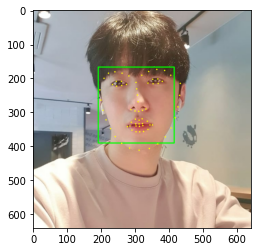

In [9]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 스티커 적용

먼저, 코의 중심점의 좌표를 확인해보자.

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))


(308, 269)
(x,y) : (308,157)
(w,h) : (224,224)


스티커 이미지를 적용해보자. 

먼저 스티커 이미지를 불러오겠다.

In [11]:
sticker_path = 'EP03_data/crown.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(224, 224, 3)


In [12]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (196,-67)


Top-Left 의 y 좌표가 음수가 나온다. 즉, 스티커가 이미지 범위 밖에 있다는 것을 의미한다.  

opencv 데이터는 numpy ndarray 형태의 데이터를 사용한다. ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해주어야한다.  

따라서 원본 이미지의 범위를 벗어난 스티커 부분을 제거해주겠다.

In [13]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(157, 224, 3)


`-y` 크기 만큼 스티커를 crop 한다.

In [14]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (196,0)


op 의 y 좌표는 원본 이미지의 경계 값으로 수정한다.

In [15]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

`sticker_area` 는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지이다.

스티커 이미지에서 사용할 부분은 `0` 이 아닌 색이 있는 부분을 사용합니다.  
따라서 `np.where` 를 통해 `img_sticker` 가 0 인 부분은 `sticker_area`를 사용하고 0이 아닌 부분을 img_sticker를 사용한다.

이후 img_show 에 다시 적용하여 결과 이미지를 출력하자.

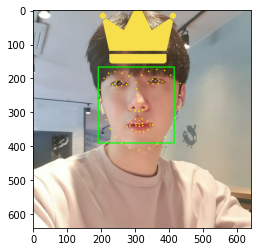

In [16]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

`img_show` 대신, 지금까지 아껴 두었던 `img_rgb` 를 활용하여  bounding box와 landmark를 제거하고 최종 결과만 출력한다.

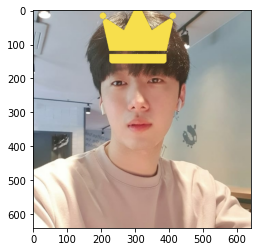

In [17]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

얼굴을 인식하여 적절한 위치에 스티커가 적용된 모습을 볼 수 있다.